In [1]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)


In [1]:
import os #to easier navigate in files
import time #keep tracking on movements
import uuid #create uniform uniqe identifier for images
import cv2

In [2]:
IMAGE_PATH = os.path.join('data', 'images')
number_of_images = 30

In [11]:
# capture = cv2.VideoCapture(0) #stablish connection to the camera, the camera number may be different depends in the device
# for image in range(number_of_images):#iterate trough images
#     print(f'Collecting image {image}') #print each image in images
#     return_value, frame = capture.read() #read from capture device that did it even capture something and the frames
#     image_name = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg') #define the name of the file of the image with unique name
#     cv2.imwrite(image_name, frame) #save the frame into the file
#     cv2.imshow('frame', frame) #display it
#     time.sleep(1) #apply delay

#     #easly breake the loop by press q
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# capture.release()
# cv2.destroyAllWindows()

In [12]:
!labelme #open label me and labeling face on the images 

fish: Unknown command: labelme
fish: 
labelme #open label me
^~~~~~^


In [4]:
#!pipenv install matplotlib numpy
import tensorflow as tf
import numpy as np #to data preproccessing
import cv2
import json
from matplotlib import pyplot as plt #to visualize images

2024-02-03 11:30:52.151847: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 11:30:52.346611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 11:30:52.346682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 11:30:52.385715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 11:30:52.469145: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 11:30:52.470582: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
#limit gpu memory growth to avoid OutOfMemory error by setting GPU Memory Cons Growth and check GPU availablity
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPUs are available.")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPUs are not available.TensorFlow will automatically use the CPU.")

GPUs are not available.TensorFlow will automatically use the CPU.


In [133]:
#load image to tensorflow data pipeline
# images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)
#load image
def load_image(file_path):
    byte_encoded_image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_encoded_image)
    return image

In [132]:
images = images.map(load_image) #apply load_image func to each element of dataset(images)
images.as_numpy_iterator().next()
type(images) # check that is tensorflow data pipeline
image_generator = images.batch(4).as_numpy_iterator() 


NameError: name 'images' is not defined

In [10]:
plot_image = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_image' is not defined

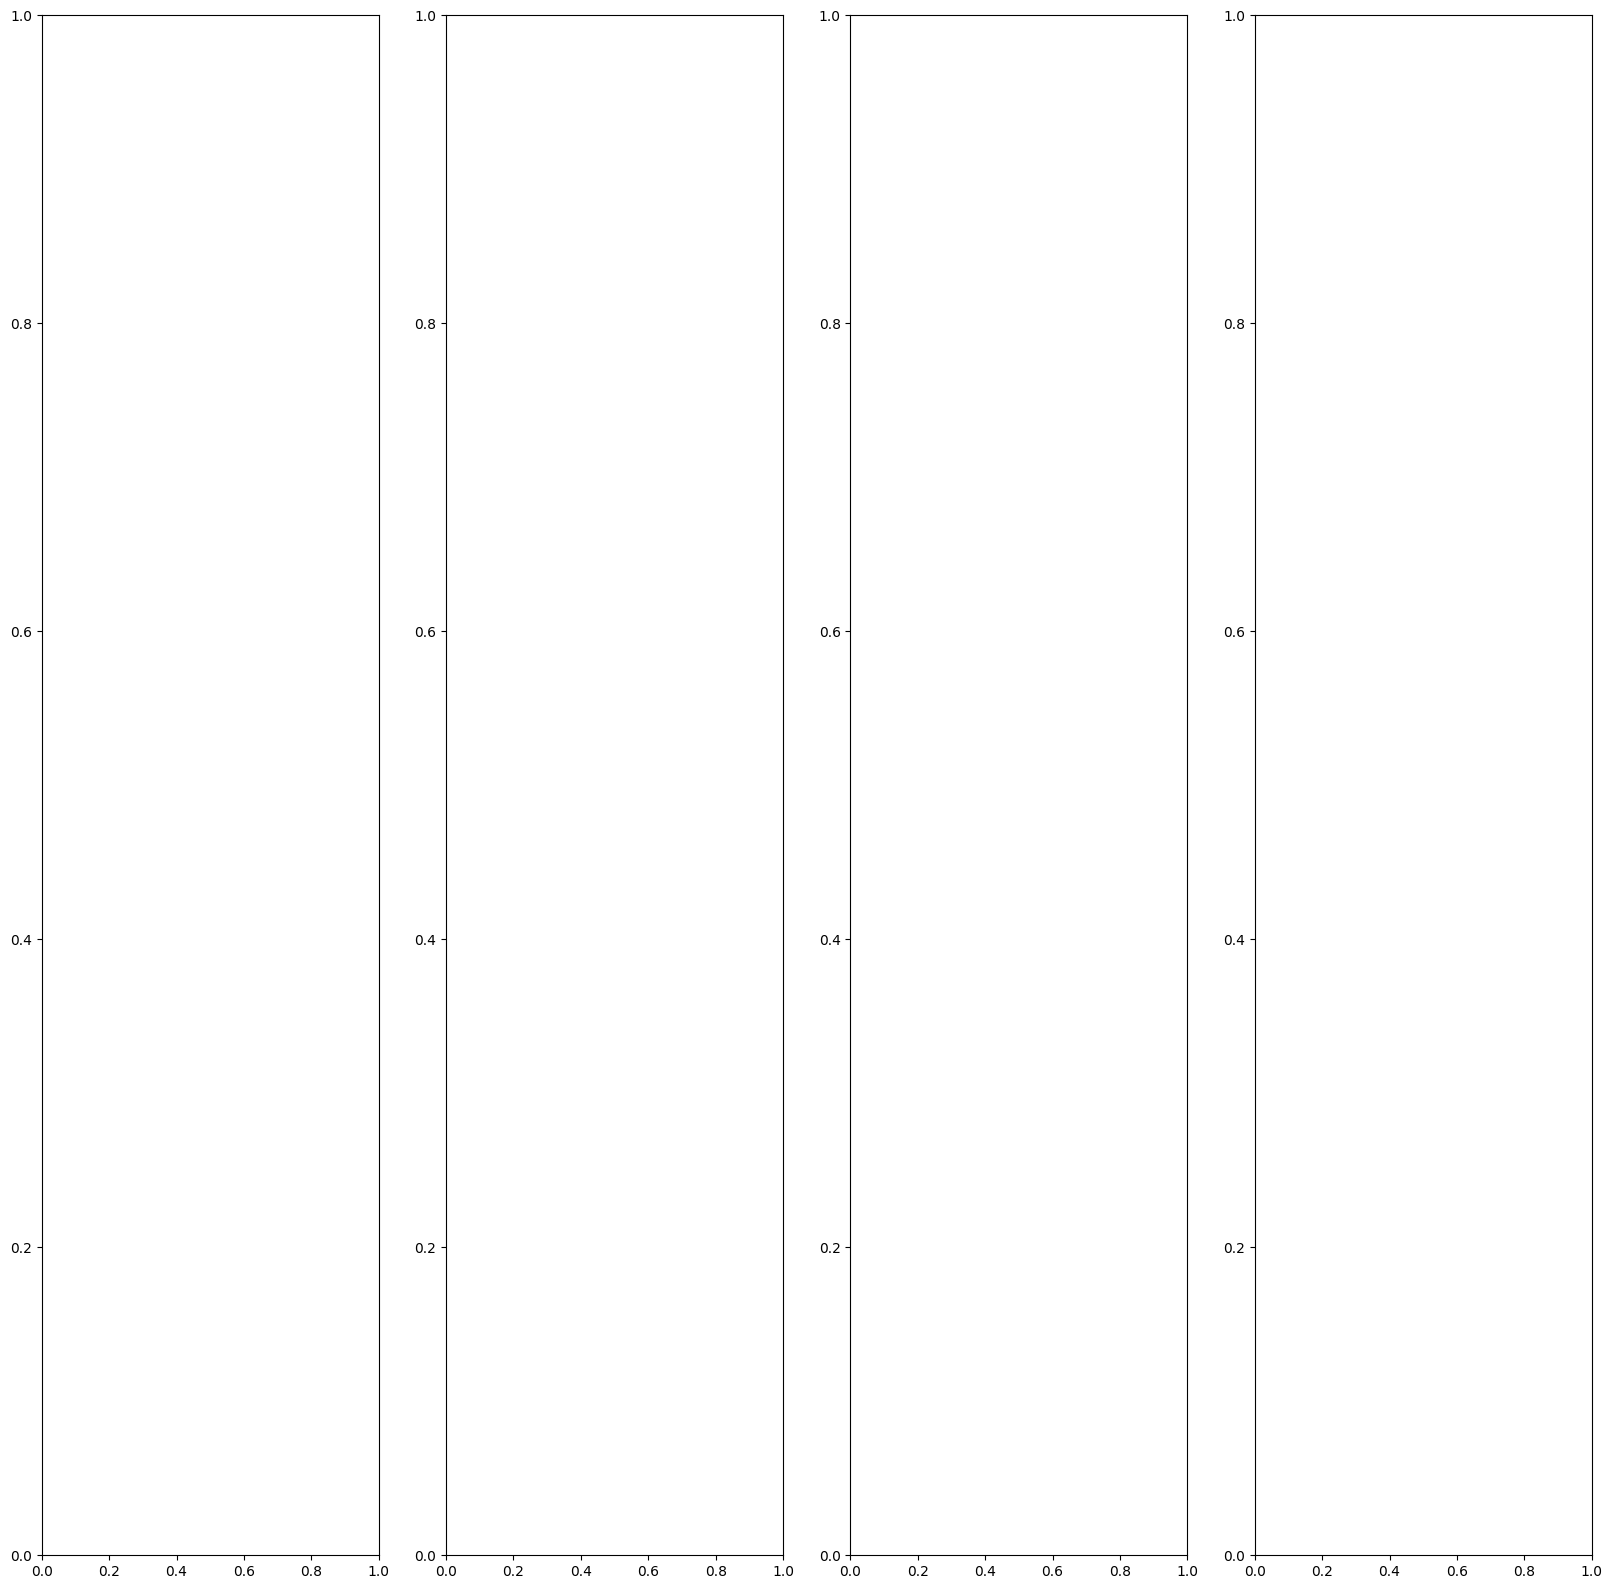

In [11]:
fig, ax =plt.subplots(ncols=4, figsize = (20, 20))
for idx , image in enumerate(plot_image):
    ax[idx].imshow(image)
plt.show()

apply 70% of the images to training
apply 15% of the rest to test and val (each)

In [99]:
#moving labels to corresponded image dir
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [120]:
#check width and height of the images, that we not exceed the actual size while cropping
from pathlib import Path
import random
selected_img_path = random.choice(list(Path('data/train/images').glob('*.jpg')))
img = cv2.imread(str(selected_img_path))
#print(selected_img_path)
img.shape
selected_img_path

PosixPath('data/train/images/e0254cea-c1c5-11ee-a8c0-983b8fb7861c.jpg')

In [101]:
import albumentations as alb

In [116]:
# create an augmentation pipeline
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)],
                         bbox_params = alb.BboxParams(format='albumentations', label_fields=['class_labels'], min_visibility=0.1))

In [121]:
img = cv2.imread(os.path.join(selected_img_path))
selected_annotation_path = selected_img_path.stem + '.json'
#print(selected_annotation_path)
with open(os.path.join('data', 'train', 'labels', str(selected_annotation_path)), 'r') as f:
           label = json.load(f)

#get the points from dict label
#label['shapes'][0]['points']
label['shapes'][0]['points']


[[0.512820512820511, 235.64102564102564], [189.16715147597506, 479.0]]

In [122]:
coordinates = [coord for point in label['shapes'][0]['points'] for coord in point]
x_min, y_min = min(coordinates[0], coordinates[2]), min(coordinates[1], coordinates[3])
x_max, y_max = max(coordinates[0], coordinates[2]), max(coordinates[1], coordinates[3])
height, width = img.shape[:2]
coordinates = [x_min / width, y_min /
                          height, x_max / width, y_max / height]

#devide each point's coordinates from the image by the width and height
#coordinates = np.divide(coordinates, [640, 480, 640, 480])
# coordinates = [coord for point in label['shapes'][0]['points'] for coord in point]

# #devide each point's coordinates from the image by the width and height
# coordinates = list(np.divide(coordinates, [640, 480, 640, 480]))

coordinates

[0.0008012820512820484,
 0.4909188034188034,
 0.29557367418121105,
 0.9979166666666667]

In [123]:
#augment and view result
augment = augmentor(image=img, bboxes = [coordinates], class_labels = ['face'])
augment['image']

array([[[ 31,  30,  35],
        [ 32,  31,  36],
        [ 35,  34,  39],
        ...,
        [ 49,  41,  43],
        [ 52,  45,  46],
        [ 55,  48,  49]],

       [[ 31,  30,  35],
        [ 32,  31,  36],
        [ 32,  31,  36],
        ...,
        [ 55,  49,  50],
        [ 56,  50,  51],
        [ 58,  52,  53]],

       [[ 28,  27,  30],
        [ 30,  28,  31],
        [ 28,  27,  30],
        ...,
        [ 53,  51,  51],
        [ 55,  52,  52],
        [ 59,  57,  57]],

       ...,

       [[186, 187, 184],
        [187, 188, 184],
        [186, 187, 184],
        ...,
        [202, 207, 205],
        [205, 208, 206],
        [203, 206, 204]],

       [[187, 188, 186],
        [186, 187, 185],
        [187, 188, 186],
        ...,
        [204, 207, 205],
        [206, 206, 206],
        [207, 207, 207]],

       [[187, 188, 186],
        [186, 187, 185],
        [188, 189, 187],
        ...,
        [206, 207, 205],
        [203, 203, 203],
        [202, 202, 202]]

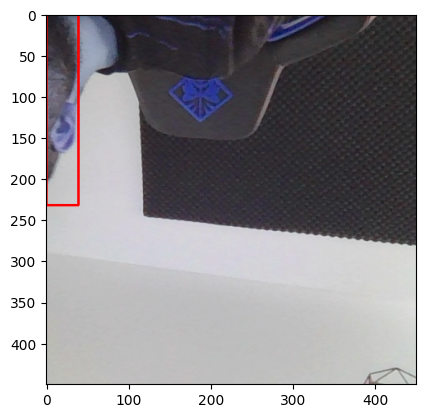

In [124]:
cv2.rectangle(augment['image'],
              tuple(np.multiply(augment['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augment['bboxes'][0][2:], [450, 450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augment['image'])

In [145]:
#run augmentation pipeline on all the images
for partition in ['train', 'test', 'val']: # loop trough training testing and validation folders
    for image in os.listdir(os.path.join('data', partition, 'images')):#grab every single image inside of there
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        coordinates = [0, 0, 0.00001, 0.00001] #if annotation doesn't exist it assign to 0
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if partition == 'val':
            print(img)
        if os.path.exists(label_path): #check annotation exit for that image
            with open(label_path, 'r') as f:
                label = json.load(f)

                coordinates = [coord for point in label['shapes'][0]['points'] for coord in point]
                x_min, y_min = min(coordinates[0], coordinates[2]), min(coordinates[1], coordinates[3])
                x_max, y_max = max(coordinates[0], coordinates[2]), max(coordinates[1], coordinates[3])
                height, width = img.shape[:2]
                coordinates = [x_min / width, y_min /
                                        height, x_max / width, y_max / height]
                # coordinates = [coord for point in label['shapes'][0]['points'] for coord in point]

                # #devide each point's coordinates from the image by the width and height
                # coordinates = list(np.divide(coordinates, [640, 480, 640, 480]))
                try:
                    #create 60 augmented from pare base images
                    for x in range(60):
                        #running data through augmentation pipeline
                        augment = augmentor(image=img, bboxes = [coordinates], class_labels = ['face'])
                        cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augment['image'])

                        annotation = {}
                        annotation['image'] = image

                        if os.path.exists(label_path):
                            if len(augment['bboxes']) == 0:
                                annotation['bbox'] = [0, 0, 0, 0]
                                annotation['class'] = 0
                            else:
                                annotation['bbox'] = augment['bboxes'][0]
                                annotation['class'] = 1
                        else:
                            annotation['bbox'] = [0, 0, 0, 0]
                            annotation['class'] = 0

                        with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                            json.dump(annotation, f)

                except Exception as err:
                    print(err)


[[[158 160 160]
  [166 168 168]
  [162 164 164]
  ...
  [250 255 254]
  [252 254 254]
  [253 255 255]]

 [[157 159 159]
  [161 163 163]
  [158 160 160]
  ...
  [251 255 255]
  [253 255 255]
  [253 255 255]]

 [[153 158 157]
  [153 158 157]
  [153 158 157]
  ...
  [250 255 254]
  [252 254 254]
  [252 254 254]]

 ...

 [[103 116 114]
  [102 115 113]
  [105 118 116]
  ...
  [202 206 187]
  [203 207 188]
  [202 206 187]]

 [[103 117 115]
  [101 115 113]
  [105 118 116]
  ...
  [204 208 189]
  [206 210 191]
  [206 210 191]]

 [[102 116 114]
  [100 114 112]
  [104 117 115]
  ...
  [203 207 188]
  [204 208 189]
  [204 208 189]]]
[[[176 164 164]
  [175 163 163]
  [174 164 164]
  ...
  [251 255 247]
  [252 255 246]
  [252 255 246]]

 [[180 168 168]
  [176 166 166]
  [176 166 166]
  ...
  [246 251 242]
  [248 251 242]
  [249 252 243]]

 [[177 167 167]
  [175 165 165]
  [175 165 165]
  ...
  [243 247 241]
  [242 246 240]
  [242 246 240]]

 ...

 [[ 17  13  18]
  [ 18  14  19]
  [ 19  16  18]
  ..

In [147]:
#load augmented imgs to tensorflow
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [148]:
train_images.as_numpy_iterator().next()

array([[[0.6578431 , 0.65539217, 0.67058825],
        [0.6480392 , 0.64411765, 0.6661765 ],
        [0.65324754, 0.64932597, 0.6713848 ],
        ...,
        [0.86942405, 0.88118875, 0.8537378 ],
        [0.874326  , 0.8824755 , 0.8622549 ],
        [0.8675245 , 0.8799632 , 0.8666667 ]],

       [[0.6699142 , 0.6699142 , 0.66501224],
        [0.67107844, 0.67107844, 0.67107844],
        [0.6783701 , 0.6783701 , 0.6852328 ],
        ...,
        [0.85876226, 0.8666054 , 0.84797794],
        [0.86268383, 0.86354166, 0.8544118 ],
        [0.8797794 , 0.8797794 , 0.8723039 ]],

       [[0.67058825, 0.67058825, 0.67058825],
        [0.66672796, 0.66672796, 0.66672796],
        [0.6670343 , 0.6670343 , 0.6670343 ],
        ...,
        [0.8586397 , 0.86648285, 0.85471815],
        [0.8628064 , 0.8706495 , 0.8657476 ],
        [0.86746323, 0.8821691 , 0.87824756]],

       ...,

       [[0.03002451, 0.02218137, 0.03394608],
        [0.02738971, 0.02052696, 0.02395833],
        [0.02401961, 0

In [160]:
def parse_label(label_path):
    # Note: tf.py_function expects the callable to return one or more tensors.
    # Here, `load_labels` should return tensors corresponding to class labels and bounding boxes.
    # The output types are specified as [tf.uint8, tf.float32] to match the expected return types.
    return tf.py_function(load_labels, [label_path], [tf.uint8, tf.float32])



#label loading function
def load_labels(label_path):
    # with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
    #     label = json.load(f)
    # return [label['class'], label['bbox']]

    # Decode the input tensor to a string
    label_path = label_path.numpy().decode('utf-8')

    with open(label_path, 'r', encoding="utf-8") as f:
        label = json.load(f)
    
    # Convert data to the appropriate types and return as tensors
    class_label = np.array(label['class'], dtype=np.uint8)
    bbox = np.array(label['bbox'], dtype=np.float32)
    
    # Ensure you return TensorFlow tensors
    return tf.convert_to_tensor(class_label, dtype=tf.uint8), tf.convert_to_tensor(bbox, dtype=tf.float32)

In [177]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(parse_label)

In [178]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(parse_label)

In [179]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
# val_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(parse_label)

In [180]:
test_labels.as_numpy_iterator().next()

(1, array([0.        , 0.22649573, 0.19623932, 0.57977206], dtype=float32))

In [181]:
#check partition lenght
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4380, 4380, 840, 840, 780, 780)

In [182]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [183]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [184]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [185]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [193]:
#View images and annotations
data_sample = train.as_numpy_iterator()

In [194]:
res = data_sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


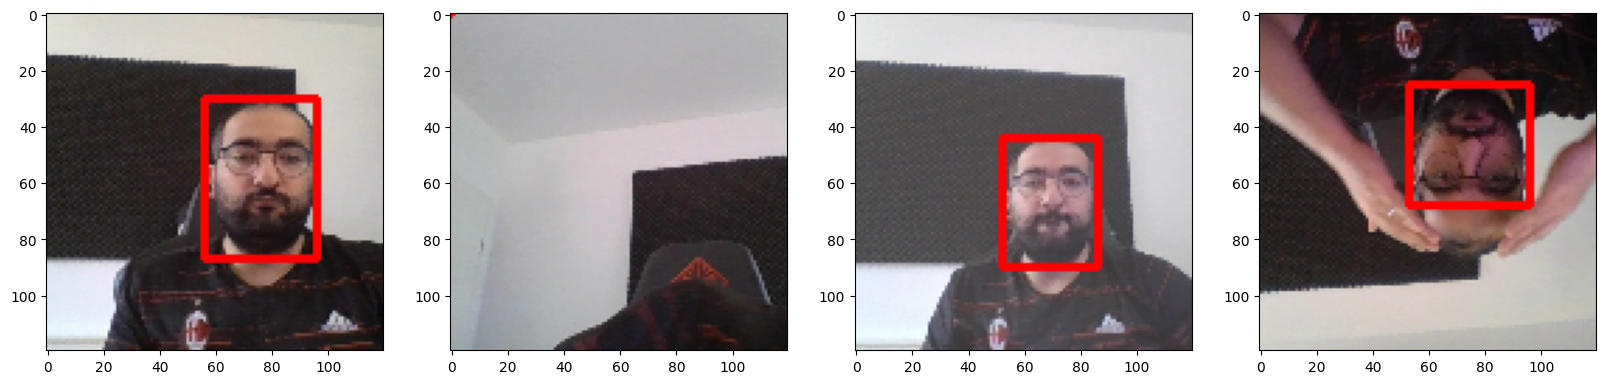

In [195]:
#plotting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coordinates = res[1][1][idx]
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coordinates[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coordinates[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)
    ax[idx].imshow(sample_image)

Deep Learning Model

In [201]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [204]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [208]:
#Network's instance
def model_builder():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    #classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    #regression model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


In [209]:
facetracker = model_builder()

In [210]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [211]:
x, y = train.as_numpy_iterator().next()
x.shape
classes, coordinates = facetracker.predict(x)
classes, coordinates

Losses and Optimizers

In [216]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [222]:
#localozation loss & classification loss
def localozation_loss(y_true, yhat):
    delta_coordinate = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2])) #distance between actual coordinate and predected coordinate

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    return delta_coordinate + delta_size

#test
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localozation_loss
localozation_loss(y[1], coordinates)



<tf.Tensor: shape=(), dtype=float32, numpy=3.8816767>

Train Neural Network

In [223]:
#create custom model class
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
            super().__init__(**kwargs)
            self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, data, **kwargs):
        X, y = data
        with tf.GradientTape() as tape:
            classes, coordinates = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coordinates)

            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss": total_loss, "class_loss": batch_classloss, "localization_loss": batch_localizationloss}
    
    def test_step(self, data, **kwargs):
        X, y = data

        classes, coordinates = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coordinates)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "localization_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [224]:
model = FaceTracker(facetracker)

In [225]:
model.compile(opt, classloss, regressloss)

In [226]:
logdir='logs'

In [228]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [230]:
hist = model.fit(train.take(100), epochs=40, validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/40
100/100 [==============================] - 235s 2s/step - total_loss: 0.5425 - class_loss: 0.0955 - localization_loss: 0.4948 - val_total_loss: 0.0492 - val_class_loss: 6.9151e-04 - val_localization_loss: 0.0488
Epoch 2/40
100/100 [==============================] - 215s 2s/step - total_loss: 0.1682 - class_loss: 0.0363 - localization_loss: 0.1501 - val_total_loss: 0.0728 - val_class_loss: 0.0011 - val_localization_loss: 0.0722
Epoch 3/40
100/100 [==============================] - 213s 2s/step - total_loss: 0.2016 - class_loss: 0.0470 - localization_loss: 0.1781 - val_total_loss: 0.0449 - val_class_loss: 0.0198 - val_localization_loss: 0.0350
Epoch 4/40
100/100 [==============================] - 214s 2s/step - total_loss: 0.0727 - class_loss: 0.0150 - localization_loss: 0.0653 - val_total_loss: 0.0208 - val_class_loss: 1.6456e-04 - val_localization_loss: 0.0208
Epoch 5/40
100/100 [==============================] - 175s 2s/step - total_loss: 0.1235 - class_loss: 0.0262 - local